In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle 

from sklearn import linear_model
import torch
from scipy.special import softmax 
from sklearn.preprocessing import StandardScaler

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
from pyro.infer import Predictive
from sklearn.model_selection import train_test_split

### Data Processing

In [2]:
scaler = StandardScaler()

In [3]:
#Use your own local path please!
path = "./Data/"
file_name = ["train.csv", "test.csv", "submission.csv"]
df_train = pd.read_csv(path + file_name[0])
df_test = pd.read_csv(path + file_name[1])
df_submission = pd.read_csv(path + file_name[2])

In [4]:
df_train['key'] = df_train['key'].fillna(df_train['key'].mean())

In [5]:
df_train['instrumentalness'] = df_train['instrumentalness'].fillna(df_train['instrumentalness'].mean())

In [6]:
df_train['Popularity'] = df_train['Popularity'].fillna(df_train['Popularity'].mean())

In [7]:
df = df_train.drop(['Artist Name','Track Name'],axis=1).copy()

In [8]:
df_sampled = df.sample(1400,random_state=47)

In [9]:
df_features = df_sampled.iloc[:,:-1].copy()
df_target = df_sampled.iloc[:,-1].copy()

In [10]:
df_features = scaler.fit_transform(df_features)

In [11]:
df_train_features, df_test_features,df_train_target, df_test_target =  train_test_split(df_features,df_target,stratify=df_target,random_state=47, test_size=1/7)

df_train_features, df_val_features,df_train_target, df_val_target =  train_test_split(df_train_features,df_train_target,stratify=df_train_target,random_state=47, test_size=1/6)

In [12]:
df_train_target = df_train_target.to_numpy()
df_test_target = df_test_target.to_numpy()
df_val_target = df_val_target.to_numpy()

In [13]:
D = df_train_features.shape[1]
N_train = df_train_features.shape[0]
N_test = df_test_features.shape[0]
N_val = df_val_features.shape[0]
n_cat = 11 
degF=4
tau=1

### Ancestral Sampling 

In [14]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [15]:
# sample coefficients (beta)
beta = np.random.normal(0,1,size=D)
print("beta:", beta)

beta_array = np.zeros((n_cat,D))

for i in range(n_cat):
    
    beta_array[i,:] = np.random.normal(0,1,size=D)
    
# sample observations (y's)
y = np.zeros((N_train,n_cat))
for n in range(N_train):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([(np.dot(beta_array[i,:], df_train_features[n,:]))])
        
    p =  softmax(probs)
    y[n,:] = np.random.multinomial(1, p)  #binomial with one trial is equivalent to bernoulli
    #y[n] = int(p > 0.5) # alternative version without observation noise
    #print(" p=, y[n]="  (n, p, y[n,:]))
    #print('n, p and y ', n, p, y[n,:])

beta: [-2.08694479  0.22566742  2.2921824   0.02423851 -0.12521575 -1.08419705
 -0.07047797 -2.44606184  0.26819663  0.75673941 -0.13984383 -0.50411163
 -1.5084009  -0.00811891]


In [16]:
label_array = np.array([]) 
for i in y:
    label_array = np.append(label_array,np.argmax(i))

In [17]:
from collections import Counter

counts = Counter(label_array)
counts

Counter({5.0: 85,
         0.0: 124,
         4.0: 104,
         3.0: 129,
         6.0: 101,
         7.0: 103,
         2.0: 121,
         1.0: 81,
         8.0: 89,
         10.0: 39,
         9.0: 24})

In [18]:
print("Accuracy:", 1.0*np.sum(label_array == df_train_target.flatten()) / len(df_train_target))

Accuracy: 0.076


In [114]:
df_train_features.shape

(1000, 14)

### FFNN

In [49]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [235]:
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
class FFNN(PyroModule):
    def __init__(self, n_in, n_hidden, n_out):
        super(FFNN, self).__init__()
        
        # Architecture
        self.in_layer = PyroModule[nn.Linear](n_in, n_hidden)
        self.in_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_in]).to_event(2))

        self.h_layer = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.h_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))

        self.out_layer = PyroModule[nn.Linear](n_hidden, n_out)
        self.out_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_out, n_hidden]).to_event(2))

        # Activation functions
        self.tanh = nn.Tanh()
        
    def forward(self, X, y=None):
        X = self.tanh(self.in_layer(X))
        X = self.tanh(self.h_layer(X))
        X = self.out_layer(X)
        # prediction_mean = X.squeeze(-1)
        # print(X.shape)
        prediction_mean = torch.nn.functional.softmax(X,dim=0)
        prediction_mean = torch.reshape(prediction_mean,(X.shape[0],11))
        # print(prediction_mean[0])
        with pyro.plate("observations"):
            # y = pyro.sample("obs", dist.Normal(prediction_mean, 0.1), obs=y)
            y = pyro.sample("obs",dist.Categorical(logits=prediction_mean),obs=y)
            # print(y.shape)
            y = torch.argmax(y)
            # print(y.shape)
        #  acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
        return y

df_train_features_tensor, df_train_target_tensor = torch.tensor(df_train_features).float(), torch.tensor(df_train_target).float()
df_test_features_tensor, df_test_target_tensor = torch.tensor(df_test_features).float(), torch.tensor(df_test_target).float()
df_val_features_tensor, df_val_target_tensor = torch.tensor(df_val_features).float(), torch.tensor(df_val_target).float()

In [236]:
model = FFNN(n_in=df_train_features_tensor.shape[1], n_hidden=10, n_out=11)
guide = AutoDiagonalNormal(model)
pyro.clear_param_store()

In [237]:
# Define the number of optimization steps
n_steps = 6000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = Adam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(df_train_features_tensor, df_train_target_tensor)
    
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))
        predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("obs", "_RETURN"))
        samples = predictive(df_train_features_tensor)
        sample_obs = samples['obs'].detach().numpy().T

        # y_test_pred = np.bincount(sample_obs).argmax(axis=0)
        y_train_pred = np.array([])
        for i in sample_obs:
            y_train_pred = np.append(y_train_pred, np.bincount(i).argmax())

        # acc = multi_acc(y_test_pred,df_test_target_tensor)
        acc = 1.0*np.sum(y_train_pred == df_train_target.flatten()) / len(df_train_target)
        print("Training Accuracy:",acc)


[0] ELBO: 3047.4
Training Accuracy: 0.077
[500] ELBO: 2860.6
Training Accuracy: 0.091
[1000] ELBO: 2716.1
Training Accuracy: 0.094
[1500] ELBO: 2603.8
Training Accuracy: 0.079
[2000] ELBO: 2505.4
Training Accuracy: 0.083
[2500] ELBO: 2431.4
Training Accuracy: 0.095
[3000] ELBO: 2426.8
Training Accuracy: 0.076
[3500] ELBO: 2398.2
Training Accuracy: 0.087
[4000] ELBO: 2401.4
Training Accuracy: 0.087
[4500] ELBO: 2398.4
Training Accuracy: 0.081
[5000] ELBO: 2398.1
Training Accuracy: 0.094
[5500] ELBO: 2397.0
Training Accuracy: 0.087


In [238]:
from pyro.infer import Predictive

# predictive = Predictive(model, guide=guide, num_samples=2000,
#                         return_sites=("alpha", "beta"))
# samples = predictive(X_train, n_cat, degF, tau, y_train)

# Make predictions for test set
predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("obs", "_RETURN"))
samples = predictive(df_test_features_tensor)

# posterior_predictive = Predictive(model=model, guide=guide, num_samples=2000, return_sites=['_RETURN']) # Get model output using draws from the variational density 
# predictive_logits = posterior_predictive(df_test_features_tensor)['_RETURN']
# log_likelihood = dist.Categorical(logits=predictive_logits).log_prob(df_test_target_tensor).sum() / len(df_test_target_tensor)

In [239]:
sample_obs = samples['obs'].detach().numpy().T

# y_test_pred = np.bincount(sample_obs).argmax(axis=0)
y_test_pred = np.array([])
for i in sample_obs:
    y_test_pred = np.append(y_test_pred, np.bincount(i).argmax())

# acc = multi_acc(y_test_pred,df_test_target_tensor)
acc = 1.0*np.sum(y_test_pred == df_test_target.flatten()) / len(df_test_target)
print("Accuracy:",acc)

Accuracy: 0.07


### Linear Model implementation with Pyro

In [19]:
def log_reg_model(X, n_cat, degF, tau, obs=None):
    
    input_dim = X.shape[1]
    
    
    mu_beta = pyro.sample("mu_beta", dist.StudentT(df=torch.ones(n_cat)*degF, 
                                                   loc=torch.zeros(n_cat), 
                                                   scale=torch.ones(n_cat)).to_event()) # Prior for the bias mean      
    sigma_beta  = pyro.sample("sigma_beta",  dist.HalfCauchy(tau*torch.ones(n_cat)).to_event()) # Prior for the bias standard deviation
    
    beta  = pyro.sample("beta", dist.Normal(mu_beta*torch.ones(n_cat), 
                                            sigma_beta*torch.ones(input_dim, n_cat)).to_event()) # Priors for the regression coefficents

    alpha = pyro.sample("alpha", dist.Normal(torch.zeros(1, n_cat), 
                                             5.*torch.ones(1, n_cat)).to_event())  # Prior for the bias/intercept
    
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Categorical(logits=alpha + X.matmul(beta)), obs=obs)
        
    return y

In [20]:
X_train = torch.tensor(df_train_features).float()
y_train = torch.tensor(df_train_target.flatten()).float()

#### Final Linear Model training 

In [21]:
degF=4
tau=1

In [22]:
with open('alphas.pkl','rb') as f:
    mean_alpha  = pickle.load(f)

with open('betas.pkl','rb') as f:
    mean_betas  = pickle.load(f)

In [22]:
# Define guide function
guide = AutoMultivariateNormal(log_reg_model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 20000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(log_reg_model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, n_cat, degF, tau, y_train)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

In [26]:
predictive = Predictive(log_reg_model, guide=guide, num_samples=2000,
                        return_sites=("alpha", "beta"))
samples = predictive(X_train, n_cat, degF, tau, y_train)

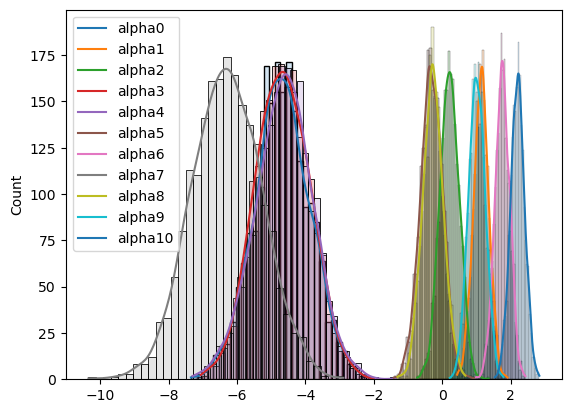

In [27]:
samples_alpha = samples["alpha"].detach().squeeze()
for c in range(n_cat):
    sns.histplot(samples_alpha[:,c], kde=True, alpha=0.2)
plt.legend(["alpha%d" % c for c in range(n_cat)])
plt.show()

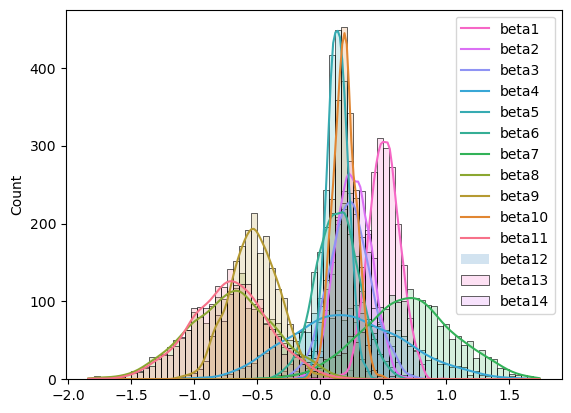

In [28]:
samples_beta = samples["beta"].detach().squeeze()
for c in range(1):
    sns.histplot(samples_beta[:,c], kde=True, alpha=0.2)
plt.legend(["beta%d" % int(int(c)+1) for c in range(D)])
plt.show()

In [31]:
mean_betas = samples_beta.mean(axis=0)
mean_betas = mean_betas.T

mean_alpha = samples_alpha.mean(axis=0)
mean_alpha = mean_alpha.T

### Inference and computation of accuracy on the train dataset 

In [23]:
# sample observations (y's)
y_train_pred = np.zeros((N_train,n_cat))
for n in range(N_train):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_train_features[n,:]))])
        
    p =  softmax(probs)
    y_train_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli

In [24]:
y_train_pred = y_train_pred[:,0]

In [25]:
print("Accuracy:", 1.0*np.sum(y_train_pred == df_train_target.flatten()) / len(df_train_target))

Accuracy: 0.492


### Inference and computation of accuracy on the test dataset 

In [26]:
# sample observations (y's)
y_test_pred = np.zeros((N_test,n_cat))
for n in range(N_test):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_test_features[n,:]))])
        
    p =  softmax(probs)
    y_test_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli

In [27]:
y_test_pred = y_test_pred[:,0]

In [28]:
print("Accuracy:", 1.0*np.sum(y_test_pred == df_test_target.flatten()) / len(df_test_target))

Accuracy: 0.455


In [ ]:
class FFNN_interpretable(PyroModule):
    def __init__(self, n_in, n_hidden, n_out):
        super(FFNN_interpretable, self).__init__()
        
        # Architecture
        self.in_layer = PyroModule[nn.Linear](n_in, n_hidden)
        self.in_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_in]).to_event(2))

        self.h_layer = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.h_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))

        self.out_layer = PyroModule[nn.Linear](n_hidden, n_out)
        self.out_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_out, n_hidden]).to_event(2))

        # Activation functions
        self.tanh = nn.Tanh()
        
    def forward(self, X, y=None):
        X_nn = X[:,1:]
        X_nn = self.tanh(self.in_layer(X_nn))
        X_nn = self.tanh(self.h_layer(X_nn))
        X_nn = self.out_layer(X_nn)
        nn_out = X_nn.squeeze(-1)

        beta_lin = mean_betas
        alpha_lin = mean_alpha
        X_linear = X[:,0]
        with pyro.plate("observations"):
            linear_out = X_linear*beta_lin
            y = pyro.sample("obs", dist.Normal(nn_out+linear_out, 0.1), obs=y)
            
        return y


DOUBLE CHECK

* fillna using KNN inputer 
* is averaging the betas giving the best result for the predictions 
* is ancentral sampling correct? 
* Consider different distributions for priors

Done

* Have priors for mean and variance for betas and alphas - parameter tuning 
* Train model on more data - currently 100 
* Feature engineer name and album name and retrain logistic regression model using these attributes
* Train model on more data (like 10000)
* Hyper parameter tuning

TODO

* Extend it with FFNN 
